In [58]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten, MultiHeadAttention, LayerNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Bidirectional, Attention

In [59]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)

    # Match the dimensions of the attention output
    attention_output_dim = attention_output.shape[-1]
    attention_output = Dense(attention_output_dim)(attention_output)

    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward part
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(attention_output_dim)(ffn_output) # Match the dimensions of the attention output
    ffn_output = Dropout(dropout)(ffn_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return sequence_output

In [60]:
# Read and preprocess data
data = pd.read_csv('E:/BTC-USD.csv')
X = []
Y = []
window_size = 100
for i in range(1, len(data) - window_size - 1, 1):
    first = data.iloc[i, 4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((data.iloc[i + j, 4] - first) / first)
    temp2.append((data.iloc[i + window_size, 4] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

In [61]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0], 1, 100, 1)
test_X = test_X.reshape(test_X.shape[0], 1, 100, 1)

In [62]:
# Input layer
inputs = Input(shape=(1, 100, 1))

# Model definition
model = tf.keras.Sequential()

# CNN layers
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(inputs)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(128, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Flatten())(x)

# Transformer encoder layer
x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=512, dropout=0.1)

# LSTM layers with Attention
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Attention()([x, x])
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100, return_sequences=False))(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(1, activation='linear')(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [63]:
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=32, verbose=1, shuffle=True)
model.evaluate(test_X, test_Y)

Epoch 1/100
25/25 [==============================] - 36s 275ms/step - loss: 0.1576 - mse: 0.1576 - mae: 0.2657 - val_loss: 0.0463 - val_mse: 0.0463 - val_mae: 0.1630
Epoch 2/100
25/25 [==============================] - 4s 158ms/step - loss: 0.0652 - mse: 0.0652 - mae: 0.1820 - val_loss: 0.0335 - val_mse: 0.0335 - val_mae: 0.1438
Epoch 3/100
25/25 [==============================] - 4s 160ms/step - loss: 0.0380 - mse: 0.0380 - mae: 0.1435 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1073
Epoch 4/100
25/25 [==============================] - 15s 604ms/step - loss: 0.0273 - mse: 0.0273 - mae: 0.1113 - val_loss: 0.0473 - val_mse: 0.0473 - val_mae: 0.1465
Epoch 5/100
25/25 [==============================] - 4s 170ms/step - loss: 0.0260 - mse: 0.0260 - mae: 0.1061 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.0960
Epoch 6/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1100 - val_loss: 0.0296 - val_mse: 0.0296 - val_mae: 0.1117
Epoch 7/1

Epoch 51/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0618 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0627
Epoch 52/100
25/25 [==============================] - 1s 56ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0644 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0653
Epoch 53/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0585 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0521
Epoch 54/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0604 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0589
Epoch 55/100
25/25 [==============================] - 1s 57ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0592 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0579
Epoch 56/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0571 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0605
Epoch 57/1

7/7 [==============================] - 0s 17ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0594


[0.007446655537933111, 0.007446655537933111, 0.059352874755859375]

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

# Calculate MAE, RMSE, and R^2
mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
print('Mean Absolute Error (MAE): %f' % mae)

rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
print('Root Mean Squared Error (RMSE): %f' % rmse)

r2 = r2_score(test_Y.reshape(-1, 1), yhat_probs)
print('R2 Score: %f' % r2)

Mean Absolute Error (MAE): 0.059353
Root Mean Squared Error (RMSE): 0.086294
R2 Score: 0.986380


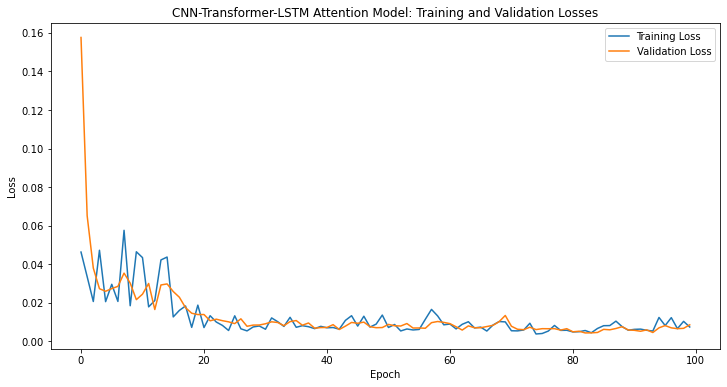

In [65]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Training Loss')
plt.plot(history.history['loss'], label='Validation Loss')
plt.title('CNN-Transformer-LSTM Attention Model: Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
df = data
# Predict the values using the trained model
predictions = model.predict(test_X)

# Reverse the normalization process
def denormalize(value, first_value):
    return value * first_value + first_value

denormalized_predictions = np.empty_like(predictions)
denormalized_test_Y = np.empty_like(test_Y)

# Apply denormalization
for i in range(len(predictions)):
    first_value = df.iloc[i + window_size, 5]
    denormalized_predictions[i] = denormalize(predictions[i], first_value)
    denormalized_test_Y[i] = denormalize(test_Y[i], first_value)
    
# Compare denormalized predictions with actual values
for i in range(len(denormalized_predictions)):
    print(f"Prediction: {denormalized_predictions[i][0].item():.2f} | Actual: {denormalized_test_Y[i][0].item():.2f}")

7/7 [==============================] - 0s 14ms/step
Prediction: 5820.08 | Actual: 6216.39
Prediction: 8634.39 | Actual: 9022.39
Prediction: 12864.08 | Actual: 13351.63
Prediction: 3747.08 | Actual: 3955.88
Prediction: 6059.48 | Actual: 6246.75
Prediction: 4905.25 | Actual: 5461.51
Prediction: 4895.80 | Actual: 4781.01
Prediction: 6385.63 | Actual: 6512.47
Prediction: 8841.00 | Actual: 8241.37
Prediction: 7314.39 | Actual: 7436.44
Prediction: 4657.56 | Actual: 4885.86
Prediction: 4021.88 | Actual: 4403.39
Prediction: 5512.57 | Actual: 5235.27
Prediction: 11856.43 | Actual: 11992.22
Prediction: 13483.91 | Actual: 13207.81
Prediction: 10760.42 | Actual: 11667.78
Prediction: 5084.61 | Actual: 5212.08
Prediction: 9505.84 | Actual: 9162.26
Prediction: 8319.27 | Actual: 8768.54
Prediction: 24059.64 | Actual: 24962.08
Prediction: 5794.08 | Actual: 5977.35
Prediction: 22353.64 | Actual: 23072.96
Prediction: 7981.99 | Actual: 7140.54
Prediction: 16696.20 | Actual: 16704.44
Prediction: 19647.49 |

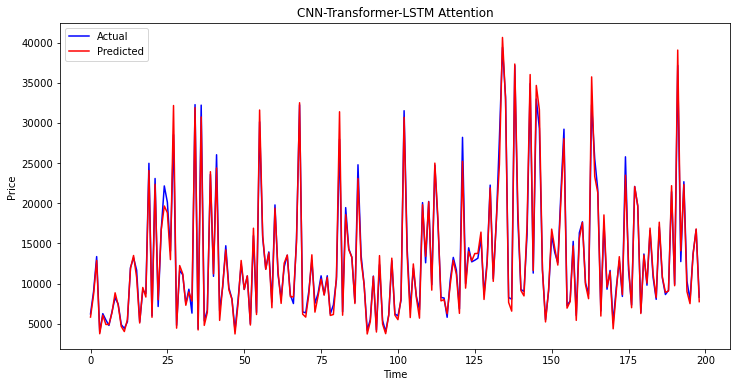

<Figure size 432x288 with 0 Axes>

In [68]:
# Flatten the denormalized_test_Y and denormalized_predictions arrays
denormalized_test_Y_flattened = denormalized_test_Y.flatten()
denormalized_predictions_flattened = denormalized_predictions.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_test_Y_flattened, label='Actual', color='blue')
plt.plot(denormalized_predictions_flattened, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('CNN-Transformer-LSTM Attention')
plt.show()
# Save the plot as an image file
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')